# Importing Libraries

In [35]:
import pandas as pd
import numpy as np

import os
import sys
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
#from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2
from keras.layers import Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [36]:
processed_data_path='../input/speecj/processed_data.csv'
df=pd.read_csv(processed_data_path)
df.shape


(48648, 2377)

In [37]:
df=df.fillna(0)
print(df.isna().any())
df.shape

0          False
1          False
2          False
3          False
4          False
           ...  
2372       False
2373       False
2374       False
2375       False
Emotion    False
Length: 2377, dtype: bool


(48648, 2377)

In [38]:
X=df.drop(labels='Emotion',axis=1)
Y=df['Emotion']
X.shape, Y.shape

((48648, 2376), (48648,))

## Data Preparation

In [39]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

lb=LabelEncoder()
Y=to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [40]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36486, 2376), (36486, 7), (12162, 2376), (12162, 7))

In [41]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36486, 2376), (36486, 7), (12162, 2376), (12162, 7))

In [42]:
# making data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.expand_dims(x_train, axis=2)

x_test = np.expand_dims(x_test, axis=2)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.expand_dims(x_test, axis=2)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36486, 1, 1, 2376), (36486, 7), (12162, 1, 1, 2376), (12162, 7))

## Modelling

In [43]:
input_shape = x_train.shape[1:]
input_shape #(108, 162, 1, 1)

(1, 1, 2376)

In [44]:
model=Sequential()

model.add(TimeDistributed(Conv1D(16, 3, padding='same', activation='relu'),
                            input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2,1))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=7, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 1, 1, 16)          114064    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 1, 1, 16)          64        
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1, 16)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)               

In [45]:
from keras.optimizers import adam_v2
optimizer = adam_v2.Adam()
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4, min_lr=0.0000001)

epochs = 30
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/30
286/286 [==============================] - 4s 9ms/step - loss: 1.7520 - accuracy: 0.2932 - val_loss: 1.6537 - val_accuracy: 0.3493
Epoch 2/30
286/286 [==============================] - 2s 6ms/step - loss: 1.5430 - accuracy: 0.3895 - val_loss: 1.4730 - val_accuracy: 0.4230
Epoch 3/30
286/286 [==============================] - 2s 6ms/step - loss: 1.4527 - accuracy: 0.4267 - val_loss: 1.4251 - val_accuracy: 0.4351
Epoch 4/30
286/286 [==============================] - 2s 6ms/step - loss: 1.4070 - accuracy: 0.4445 - val_loss: 1.3805 - val_accuracy: 0.4537
Epoch 5/30
286/286 [==============================] - 2s 6ms/step - loss: 1.3687 - accuracy: 0.4567 - val_loss: 1.3377 - val_accuracy: 0.4731
Epoch 6/30
286/286 [==============================] - 2s 6ms/step - loss: 1.3322 - accuracy: 0.4760 - val_loss: 1.3580 - val_accuracy: 0.4723
Epoch 7/30
286/286 [==============================] - 2s 6ms/step - loss: 1.3125 - accuracy: 0.4849 - val_loss: 1.3059 - val_accuracy: 0.4887
Epoch 

381/381 [==============================] - 1s 3ms/step - loss: 1.1881 - accuracy: 0.5444
Accuracy of our model on test data :  54.44005727767944 %


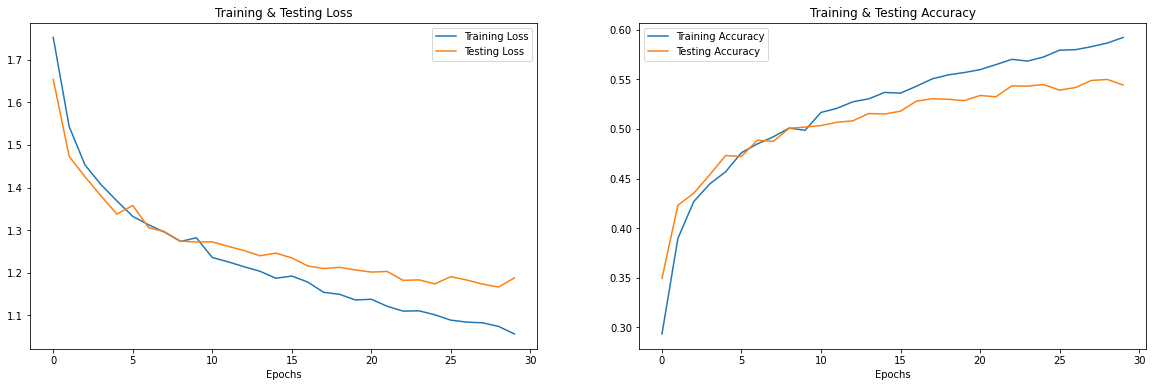

In [46]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
import pandas as pd
import numpy as np

import os
import sys
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
#from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2
from keras.layers import Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
processed_data_path='../input/speecj/processed_data.csv'
df=pd.read_csv(processed_data_path)
df.shape
df=df.fillna(0)
print(df.isna().any())
df.shape
X=df.drop(labels='Emotion',axis=1)
Y=df['Emotion']
X.shape, Y.shape
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

lb=LabelEncoder()
Y=to_categorical(lb.fit_transform(Y))
print(lb.classes_)
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# making data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.expand_dims(x_train, axis=2)

x_test = np.expand_dims(x_test, axis=2)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.expand_dims(x_test, axis=2)

x_train.shape, y_train.shape, x_test.shape, y_test.shape
input_shape = x_train.shape[1:]
input_shape #(108, 162, 1, 1)
model=Sequential()

model.add(TimeDistributed(Conv1D(16, 3, padding='same', activation='relu'),
                            input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2,1))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=7, activation='softmax'))

model.summary()